## Описание

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. .

<font size=+1><b>Описание этапов обработки: </b></font>
1. Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

2. Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

3. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры сплава.

4. Расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

<font size=+1><b>Цель: </b></font> проанализировать данные, предоставленные комбинатом, и построить модель, которая будет её предсказывать конечную температуру сплава. Разработанную модель заказчит планирует использовать для имитации технологического процесса.

<font size=+1><b>План исследования:</b></font>
1. На первом этапе произведем [загрузку данных](#1).<br>
2. На втором этапе выполним [исследовательский анализ и предобработку](#2) каждого датафрейма. На этом этапе сделаем первичные выводы об имеющихся признаках: понадобятся ли они для обучения моделей.
3. На третьем этапе [объединим](#3) выбранные признаки в один датафрейм.
4. Затем выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков и при необходимости выполним предобработку. Проведем [корреляционный анализ](#4).
5. Выполним [подготовку данных](#5) для обучения модели. Разделим данные на две выборки, при необходимости проведем масштабировании и кодировании.
6. [Обучим](#6) несколько моделей. Подберем для них гиперпараметры.
7. Проанализируем полученные результаты, [выберием лучшую модель](#7) и проверим её качество на тестовой выборке. Проведем анализ важности признаков.
8. Сделаем [общие выводы](#8) о проделанной работе, опишем основные этапы работы, полученные результаты и дадим рекомендации для заказчика.

Загрузим необходимые библиотеки.

In [1]:
# установим бибиотеки
!pip install shap -q
!pip install scikit-learn==1.2.2 -q
!pip install matplotlib==3.8.0 -q
!pip install seaborn==0.13.2 -q
!pip install scipy==1.11.4 -q
!pip install numpy==1.22.3 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.26.4 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# загрузим классы для заполнения пропусков
from sklearn.impute import SimpleImputer

# загрузим классы для преобразования данных
from sklearn.preprocessing import StandardScaler

# загрузим нужные модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

# импортируем функцию для кросс-валидации
from sklearn.model_selection import cross_val_score

# загрузим инструменты для автоматизированного подбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV

# загрузим метрику
from sklearn.metrics import mean_absolute_error

import shap

# загрузим дамми-модель
from sklearn.dummy import DummyRegressor

RANDOM_STATE=40624
TEST_SIZE=0.25

<a id='1'></a>
## Загрузка данных
Загрузим предоставленные данные. Для этого напишем функцию, которая выведет основную информацию о каждом датафрейме.

In [3]:
def main_info(data):
    print('Размерность датафрейма:', data.shape, '\n')
    display(data.head())
    print('\n')
    print('Основная информация:\n')
    print(data.info())
    print('\n')
    print('Статистические данные:\n')
    display(data.describe())
    print('\n')
    print('Количество пропусков:\n')
    print(data.isna().sum())

### Данные об электродах

In [4]:
arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')

In [5]:
main_info(arc)

Размерность датафрейма: (14876, 5) 



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691




Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None


Статистические данные:



,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284




Количество пропусков:

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


В первом датафрейме 14 876 записей и 5 полей. Поля `Начало нагрева дугой` и `Конец нагрева дугой` содержат информацию о дате и времени, поэтому их необходимо привести к типу данных `datetime64`. `Активаная мощность` и `Реактивная мощность` имеют тип данных `float`. Пропусков в данных нет. Данные корректные и соответсвуют описанию. 

### Данные о подаче сыпучих материалов (объем)

In [6]:
bulk_volume = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')

In [7]:
main_info(bulk_volume)

Размерность датафрейма: (3129, 16) 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0




Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None


Статистические данные:



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000




Количество пропусков:

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


В датафрейме содержится 3129 записей и 16 полей. Поля `Bulk 1` ... `Bulk 16` содержат информацию об объеме подаваемого материала. Тип данных в полях - `float`. Присутсвует большое количество пропущенных значений, это значит, что материал не подавался.

### Данные о подаче сыпучих материалов (время)

In [8]:
bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')

In [9]:
main_info(bulk_time)

Размерность датафрейма: (3129, 16) 



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47




Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None


Статистические данные:



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000




Количество пропусков:

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


В датафрейме содержится 3129 записей и 16 полей. Поля `Bulk 1` ... `Bulk 16` содержат информацию о времени подачи материала. Тип данных в полях - `object`. В данных присутствует большое количество пропусков, это значит, что материал не подавался.

### Данные о продувке сплава газом

In [10]:
gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')

In [11]:
main_info(gas)

Размерность датафрейма: (3239, 2) 



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692




Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None


Статистические данные:



,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040




Количество пропусков:

key      0
Газ 1    0
dtype: int64


В датафрейме содержится 3129 записей и 2 поля. Поле `Газ 1` содержит информацию об объеме подаваемого газа. Тип данных в поле - `float`. Пропусков в данных нет. Данные корректны и соответсвуют описанию.

### Результаты измерения температуры

In [12]:
temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')

In [13]:
main_info(temp)

Размерность датафрейма: (18092, 3) 



,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0




Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None


Статистические данные:



,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000




Количество пропусков:

key                0
Время замера       0
Температура     3427
dtype: int64


В датафрейме содержится 18 092 записей и 3 поля. Поле `Температура` содержит значение температуры сплава. В поле `Температура` имеется 3427 пропусков. Тип данных корректный. 

### Данные о проволочных материалах (объём)

In [14]:
wire_volume = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')

In [15]:
main_info(wire_volume)

Размерность датафрейма: (3081, 10) 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None


Статистические данные:



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604




Количество пропусков:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


В датафрейме имеется 3081 запись и 10 полей. Поля `Wire 1`...`Wire 2` содержат информацию об объёме подаваемых проволочных материалов. Тип данных - `float`. В данных присутствует большое количество пропусков, это значит, что материал не подавался. 

### Данные о проволочных материалах (время)

In [16]:
wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')

In [17]:
main_info(wire_time)

Размерность датафрейма: (3081, 10) 



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Основная информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None


Статистические данные:



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000




Количество пропусков:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


В датафрейме имеется 3081 запись и 10 полей. Поля `Wire 1`...`Wire 2` содержат информацию о времени подачи проволочных материалов. Тип данных - `object`. В данных присутствует большое количество пропусков, это значит, что материал не подавался. 

### Вывод
Всего для работы были предоставлены 7 датафреймов, которые содержат данные об электродах, объеме и времени подачи сыпучих и проволочных материалов, данные о продувке сплава газом и результаты измерения температуры. Первичный анализ показал, что данные соответсвуют описанию. В некоторых дататфреймах пропущенные значения составлют значительную часть от всех данных, такие пропуски нужно будет обработать. Также необходимо будет провести проверку на аномалии, после чего объеденить все датафреймы по общему полю `key` - номеру партии, так как объектом моделирования является конечная температура сплава в ковше.

<a id='2'></a>
## Исследовательский анализ и предобработка данных.
Выполним исследовательский анализ каждого признака: построим гистограммы и диаграммы размаха. При необходимости выполним первичную предобработку данных. На основании проведенного анализа сделаем выводы об имеющихся признаках: понадобятся ли они для обучения моделей.

Напишем функцию, которая будет строить гистограммы распределения и диаграммы размаха для передаваемых признаков.

In [18]:
def hist_boxplot(data, name_column, num=10):
    print (f'Статистические данные по столбцу "{name_column}"')
    display(data.describe())
    fid, ax = plt.subplots(2,1, figsize=(12,10))
    ax[0].set(title=f'Гистограмма распределения  "{name_column}"')
    data.hist(bins=num, grid=True, ax=ax[0])
    ax[0].set(xlabel=name_column)
    ax[0].set(ylabel=f'Распределение "{name_column}"')
    ax[1].set(title=f'Диаграмма размаха "{name_column}"')
    sns.boxplot(data=data, orient='h', ax=ax[1])
    plt.show()

### Данные об электродах
Изменим тип данных в полях `Начало нагрева дугой` и `Конец нагрева дугой` на `datetime`.

In [19]:
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])

Теперь во всех столбцах корректный тип данных. Проверим наличие полных дубликатов. Исследуем `Активную мощность` и `Реактивную мощность`, для этого построим гистограммы распределения и диаграммы размаха.

In [20]:
print('Количество полных дубликатов:', arc.duplicated().sum())

Количество полных дубликатов: 0


Статистические данные по столбцу "Активная мощность"


count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

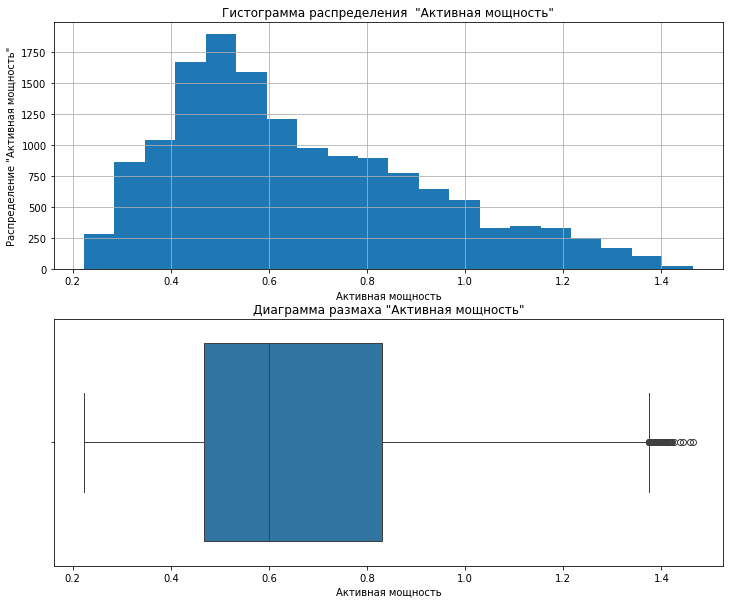

In [21]:
hist_boxplot(arc['Активная мощность'], 'Активная мощность', 20);

Медианное значение `Активной мощности` составляет 0.6 кВт. 75% измерений `Активная мощность` составляла менее 0.8 кВт. Большинство значений распределены в диапазоне от от 0.1 кВт до 1.4 кВт. Есть небольшое количество выбросов - значения `Активной мощности` свыше 1.4 кВт.

Статистические данные по столбцу "Реактивная мощность"


count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

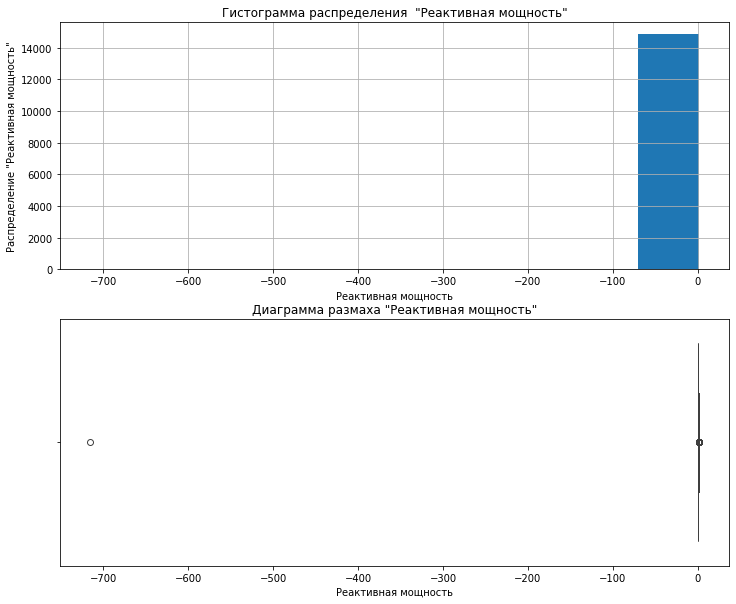

In [22]:
hist_boxplot(arc['Реактивная мощность'], 'Реактивная мощность', 10);

В `Реактивной мощности` есть аномальное значение - значение с отрицательной мощностью. Удалим его.

In [23]:
display(arc[arc['Реактивная мощность'] < 0])
#arc = arc[arc['Реактивная мощность'] >= 0]
arc = arc[arc['key'] != 2116]
print ('Размерность датафрейма после удаления аномальных значений:', arc.shape)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Размерность датафрейма после удаления аномальных значений: (14872, 5)


Мы удалили один выброс - значение `Реактивной мощности` меньше 0. Отобразим оставшие значения на диаграммах.

Статистические данные по столбцу "Реактивная мощность"


count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64

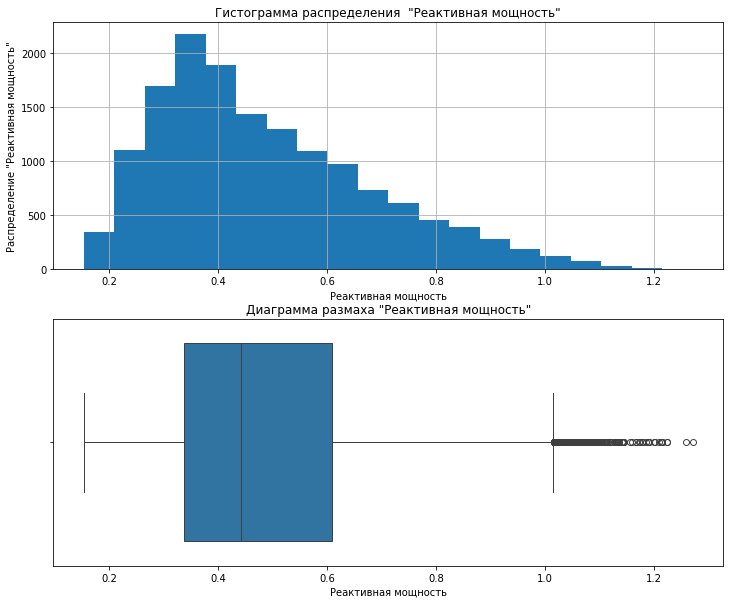

In [24]:
hist_boxplot(arc['Реактивная мощность'], 'Реактивная мощность', 20);

Среднее значение реактивной мощности составляет около 0.5 кВт. Большинство значений лежат в диапазоне от 0.1 кВт до 1.0 кВт. 75% всех измерений `Реактивной мощности` меньше 0.6 кВт. Есть большое количество выбросов - значения мощности больше 1.0 кВт.

#### Создание новых признаков
Добавим значение полной мощности, которая потребляется электроприбором и включает в себя как активную составляющую, так и составляющую реактивную. Для этого напишем функцию, которая будет вычислять `Полную мощность`.

In [25]:
def full_power (P, Q):
    S = (P**2 + Q**2)**0.5
    return S

In [26]:
arc['Полная мощность'] = full_power(arc['Активная мощность'], arc['Реактивная мощность'])

Статистические данные по столбцу "Полная мощность"


count    14872.000000
mean         0.823385
std          0.323494
min          0.275718
25%          0.578813
50%          0.746591
75%          1.030390
max          1.898158
Name: Полная мощность, dtype: float64

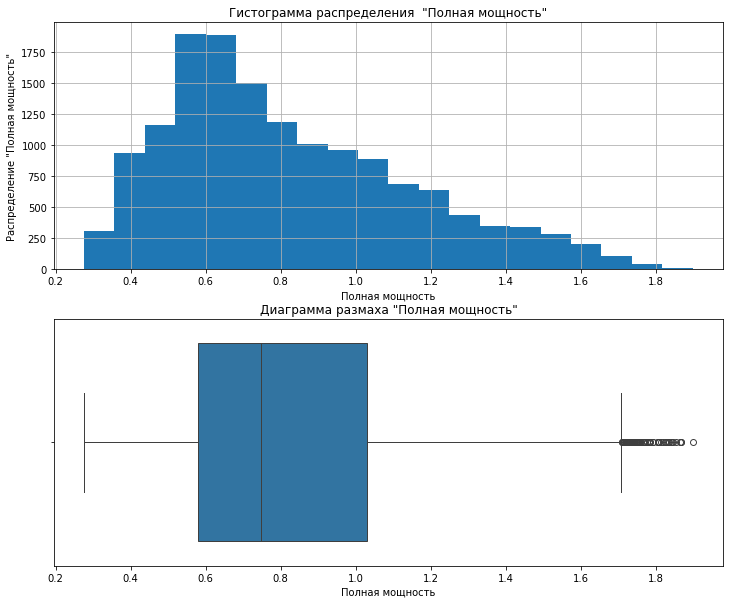

In [27]:
hist_boxplot(arc['Полная мощность'], 'Полная мощность', 20);

Среднее значение `Полной мощности` составляет 0.8 кВт. Нормальные значения лежат в пределах от 0.3 кВт до 1.7 кВт. 75% измерений `Полной мощности` были менее 1.1 кВт. Есть выбросы - значения мощности свыще 1.7 кВт.

Рассчитаем полное время работы электрической дуги.

In [28]:
arc['Время работы дуги'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']).astype('timedelta64[s]')
arc['Время работы дуги'] = (arc['Время работы дуги']).astype('int64')
# выведем пять случайных строк
arc.sample(5, random_state=RANDOM_STATE)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время работы дуги
2478,535,2019-05-23 20:10:52,2019-05-23 20:11:53,0.548530,0.342780,0.646826,61
8057,1750,2019-07-07 08:02:11,2019-07-07 08:05:03,0.278340,0.209206,0.348196,172
7813,1691,2019-07-05 15:28:56,2019-07-05 15:29:34,0.399532,0.289429,0.493351,38
1620,348,2019-05-16 20:39:06,2019-05-16 20:41:19,0.442410,0.321057,0.546630,133
11470,2504,2019-08-10 17:54:28,2019-08-10 17:57:52,0.275671,0.215778,0.350078,204


Построим распределение `Времени работы дуги` на одну итерацию.

Статистические данные по столбцу "Время работы дуги"


count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: Время работы дуги, dtype: float64

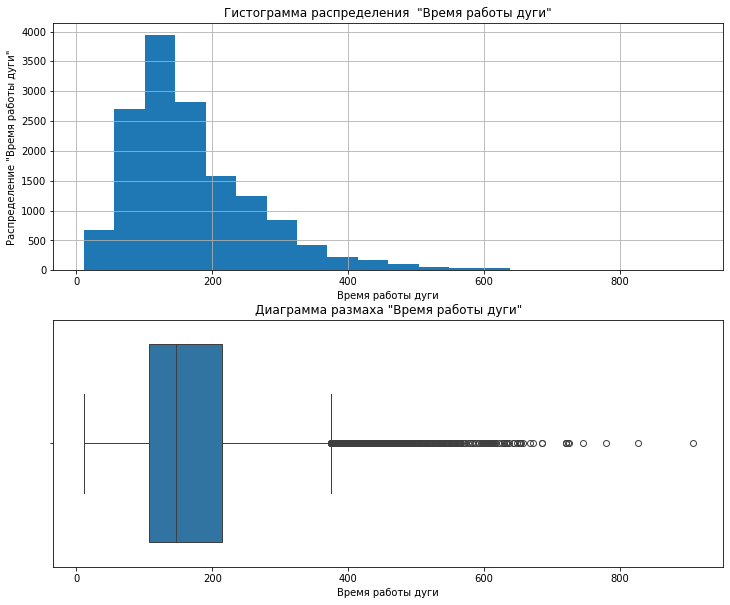

In [29]:
hist_boxplot(arc['Время работы дуги'], 'Время работы дуги', 20);

Среднее значение `Времени работы дуги`  для одной итерации составляет около 170 секунд. Нормальное время работы дуги находится в пределах от нескольких секунд до 6.5 минут. Есть выбросы - дуга работала более 6.5 минут. Самое большое время работы составило 907 секунд (15 минут). Аномально больших значений (дуга работала несколько часов) - нет. 

Составим сводную таблицу, сгруппировав все значению по  ключу - номеру партии `key`, и рассчитав сумарное значение мощностей и времени работы дуги.

In [30]:
arc_agg = arc.pivot_table(index='key', values=['Активная мощность', 'Реактивная мощность', 
                                               'Полная мощность', 'Время работы дуги'], aggfunc='sum')
arc_agg

,Активная мощность,Время работы дуги,Полная мощность,Реактивная мощность
key,,,,
1,3.036730,1098,3.718736,2.142821
2,2.139408,811,2.588349,1.453357
3,4.063641,655,5.019223,2.937457
4,2.706489,741,3.400038,2.056992
5,2.252950,869,2.816980,1.687991
...,...,...,...,...
3237,2.541872,909,3.250657,2.025417
3238,1.374821,546,1.723937,1.038103
3239,4.848005,1216,6.014480,3.541541


Выведем статистические данные по всем столбцам.

In [31]:
arc_agg.describe()

,Активная мощность,Время работы дуги,Полная мощность,Реактивная мощность
count,3213.000000,3213.000000,3213.000000,3213.000000
mean,3.067683,794.691566,3.811201,2.254693
std,1.208719,332.439136,1.502848,0.894787
min,0.267676,57.000000,0.331897,0.196228
25%,2.236693,571.000000,2.775577,1.631855
50%,2.984607,770.000000,3.694535,2.177210
75%,3.775574,983.000000,4.697427,2.788381
max,12.375636,4189.000000,15.288271,8.949049


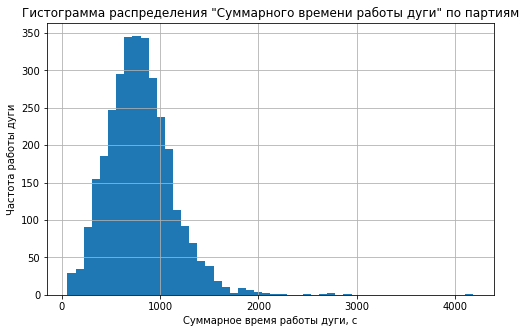

In [32]:
arc_agg['Время работы дуги'].plot(kind='hist', bins=50, grid=True, figsize=(8,5))
plt.title('Гистограмма распределения "Суммарного времени работы дуги" по партиям')
plt.xlabel('Суммарное время работы дуги, c')
plt.ylabel('Частота работы дуги');

Исследование суммарного `Времени работы дуги` показало, что среднее суммарное время на одну партию составляет около 800 секунд. Для подавляющего большинства партий суммарное время работы составило менее 2000 секунд. Максимально время работы было более 4000 секунд. Это единичное значение, которое можно отнести к выбросам. 

**Выводы:**
- Среднее значение `Активной мощности` составило 0.7 кВт, `Реактивной мощности` - 0.6 кВт.
- Было удалено одно аномальное значение `Реактивной мощности` - отрицательная мощность.
- Были добавлены новые признаки - `Полная мощности`. Среднее значение `Полная мощности` составило около 0.8 кВт.
- Были проведены исследования времени работы дуги. Среднее `Время работы дуги` для одной итерации равняется 170 секундам, аномальных значений не было выявлено.
- `Суммарное время работы дуги` на одну партию в среднем составляет около 800 секунд. Есть партии, где `Суммарное время работы дуги` значительно превышает среднее - всего дуга работала свыше 2000 секунд.

### Данные о подаче сыпучих материалов (объем)
Выведем несколько случайных строк.

In [33]:
bulk_volume.sample(5, random_state=RANDOM_STATE)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1598,1658,27.0,NaN,137.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399.0,NaN,199.0,179.0
1834,1896,41.0,NaN,51.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,510.0,NaN,200.0,210.0
1166,1214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,124.0,101.0
2739,2842,NaN,NaN,104.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,106.0
1634,1694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,130.0,106.0


Проверим наличие полных дубликатов:

In [34]:
print ('Количество полных дубликатов:', bulk_volume.duplicated().sum())

Количество полных дубликатов: 0


Построим гистограммы расределения и диаграммы размаха объема материалов `Bulk 1` ... `Bulk 15`.

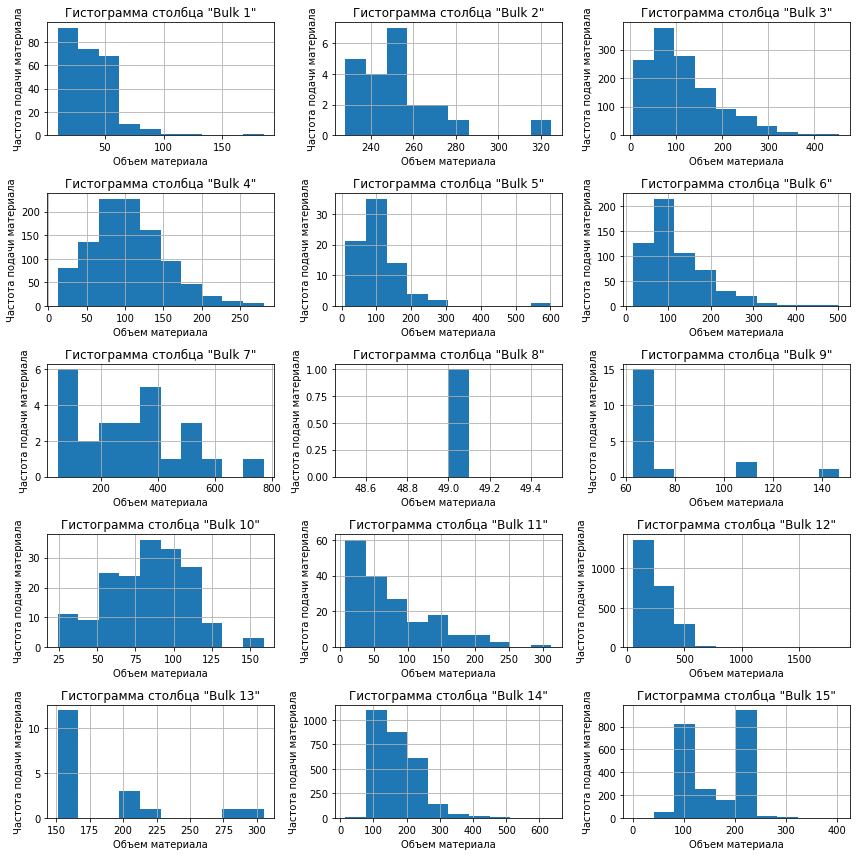

In [35]:
fig, axes = plt.subplots(5,3, figsize=(12,12))
axe = axes.ravel()
for i, col in enumerate(bulk_volume.drop('key', axis=1).columns):
    axe[i].set_title(f'Гистограмма столбца "{col}"')
    axe[i].set_xlabel('Объем материала')
    axe[i].set_ylabel('Частота подачи материала')
    bulk_volume[col].hist(bins=10, ax=axe[i])
    plt.tight_layout()

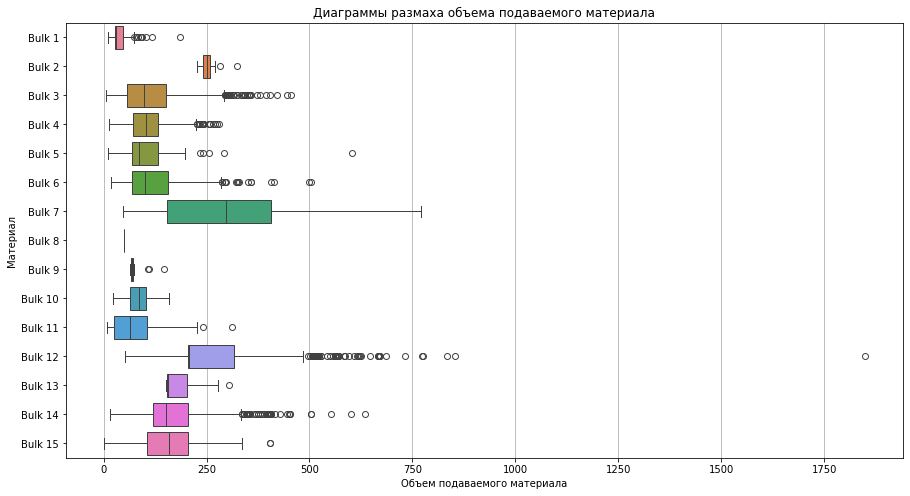

In [36]:
plt.figure(figsize=(15,8))
plt.grid(True)
sns.boxplot(bulk_volume.drop('key', axis=1), orient='h')
plt.title('Диаграммы размаха объема подаваемого материала')
plt.xlabel('Объем подаваемого материала')
plt.ylabel('Материал');

На гистограммах распределения видно, что некоторые материалы имеют выбросы по объему. Большинство значений объемов лежат в пределах от 0 до 500. У материала `Bulk 7` наибольший размах нормальных значений, примерно, от 50 до 750.

Просуммируем объем сыпучих добавок для каждой партии и посмотрим, как расспределяется суммарный объем поданных материалов по партиям.

In [37]:
bulk_volume['summ_bulk'] = bulk_volume.drop('key', axis=1).sum(axis=1)
bulk_volume.sort_values(by='summ_bulk', ascending=False).head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,summ_bulk
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN,3235.0
1629,1689,NaN,NaN,NaN,NaN,NaN,247.0,NaN,NaN,NaN,NaN,NaN,733.0,305.0,248.0,224.0,1757.0
308,327,67.0,NaN,NaN,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,775.0,NaN,403.0,205.0,1569.0
1933,1999,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,853.0,NaN,366.0,290.0,1563.0
486,513,NaN,NaN,286.0,NaN,NaN,295.0,NaN,NaN,NaN,NaN,NaN,474.0,NaN,219.0,224.0,1498.0


Изобразим Топ-10 партий с наибольшим количеством добавок на диаграмме.

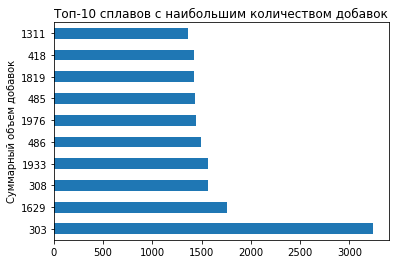

In [38]:
bulk_volume['summ_bulk'].sort_values(ascending=False).head(10).plot(kind='barh', 
                                                                        title='Топ-10 сплавов с наибольшим количеством добавок',
                                                                        xlabel='Суммарный объем добавок',
                                                                        ylabel='Номер сплава');

**Вывод:** 
- Полных дубликатов в данных нет.
- Есть пропуски, кторые необходимо будет заполнить 0 в дальнейшем.
- Наиболее часто в качестве добавки используют материалы `Bulk 3`, `Bulk 4`, `Bulk 6`, `Bulk 14`, `Bulk 16`.
- Материалы `Bulk 9` и `Bulk 13` имеют дискретное распределение.
- Материал `Bulk 8` добавляли в сплав всего один раз.
- В материала `Bulk 12` есть явная аномалия - объем добавленного материала превышает 1750.
- Больше всего материала добавили в `322` сплав - 3235, в остальных сплавах суммарный объем добавок не превышает 1800.

In [39]:
# аномалньное значение объема свыше 1750
bulk_volume[bulk_volume['Bulk 12'] > 1750]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,summ_bulk
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN,3235.0


### Данные о подаче сыпучих материалов (время)
Приведем данные о времени подачи материала к нужному формату `datetime64`.

In [40]:
for name_column in bulk_time.drop('key', axis=1).columns:
    bulk_time[name_column] = pd.to_datetime(bulk_time[name_column])

Выведем несколько первых строк из датафрейма.

In [41]:
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Сгруппируем данные по партиям. Заменим пропущенные значения на `NaT` (Not a Time).

In [42]:
bulk_time_agg = bulk_time.groupby('key').agg('first')
bulk_time_agg = bulk_time_agg.apply(lambda x: x.fillna(pd.NaT), axis=0)

Выделим первую и последнюю дату подачи материала в каждой партии.

In [43]:
bulk_time_agg['first_date'] = bulk_time_agg.min(axis=1)
bulk_time_agg['last_date'] = bulk_time_agg.max(axis=1)

Рассчитаем интервал времени между первой и последней подачей материала.

In [44]:
bulk_time_agg['Интервал подачи материала'] = (bulk_time_agg['last_date'] - bulk_time_agg['first_date']).astype('timedelta64[s]')
bulk_time_agg['Интервал подачи материала'] = (bulk_time_agg['Интервал подачи материала']).astype('int64')
bulk_time_agg.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,first_date,last_date,Интервал подачи материала
key,,,,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,2019-05-03 11:10:43,2019-05-03 11:28:48,1085
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,2019-05-03 11:36:50,2019-05-03 11:53:30,1000
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,2019-05-03 12:16:16,2019-05-03 12:32:39,983
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,2019-05-03 12:43:22,2019-05-03 12:58:00,878
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47,2019-05-03 13:30:47,2019-05-03 13:34:12,205


Проанализируем данные о времени подачи сыпучего материала. Построим гистограмму распределения и диаграмму размаха.

Статистические данные по столбцу "Интервал подачи материала"


count     3129.000000
mean       964.906679
std        798.088025
min          0.000000
25%        485.000000
50%        877.000000
75%       1311.000000
max      13683.000000
Name: Интервал подачи материала, dtype: float64

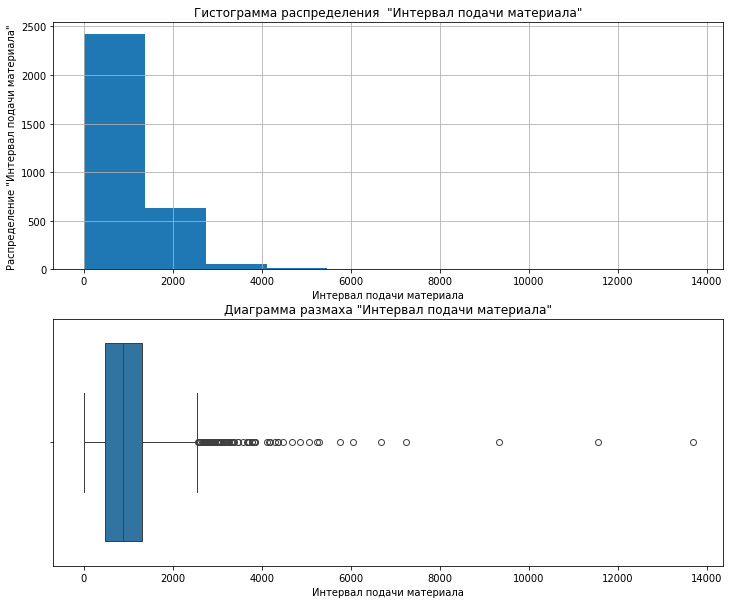

In [45]:
hist_boxplot(bulk_time_agg['Интервал подачи материала'], 'Интервал подачи материала')

**Вывод:** 
Среднее время между первой и последней добавкой сыпучих материалов составляет 965 секунд. 75% интервалов измерений находятся в пределах до 1311 секунд. Есть некоторое количество выбросов. Есть единичные случаи, когда время между первой и последней добавкой сыпучего материала, было больше 8000 секунд. Максимальное значение `Интервала подачи материала` составляет 13 683 секунд. Длительные промежутки времени могут быть обусловлены особенностями технологического процесса. Супервыбросов, когда интервал составлял бы несколько суток, нет.

### Данные о продувке сплава газом
Построим гистограммы распределения и диаграммы размаха для объема подаваемого газа `Газ 1`.

Статистические данные по столбцу "Газ 1"


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

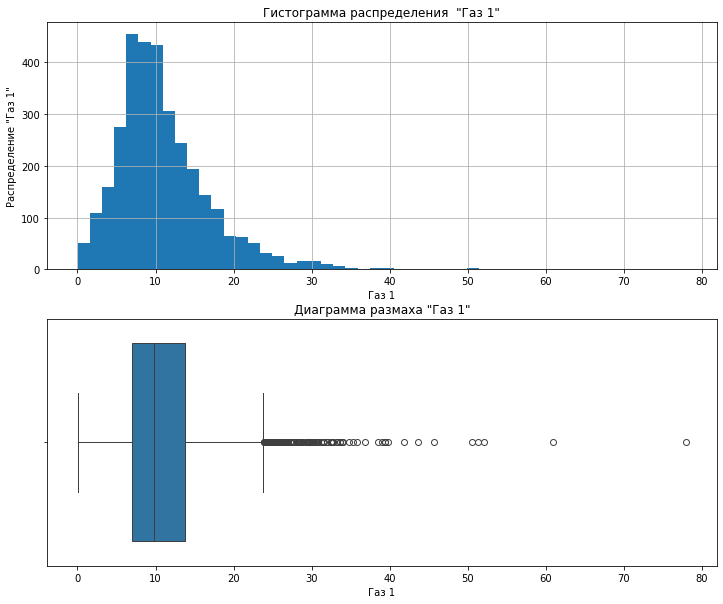

In [46]:
hist_boxplot(gas['Газ 1'], 'Газ 1', 50)

**Выводы:** 
- Средний объем подаваеомого газа составляет около 11 м3.
- 75% подаваемого газа было в объеме менее 14 м3.
- В даных есть выбросы - объем подаваемого газа более 25 м3.
- Максимальное значение подаваемого газа почти 78 м3.

### Результаты измерения температуры
Для начала приведем данные к нужному формату.

In [47]:
temp['Время замера'] = pd.to_datetime(temp['Время замера'])

Построим гистограммы распределенияи и диаграммы размаха `Температуры`.

Статистические данные по столбцу "Температура"


count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

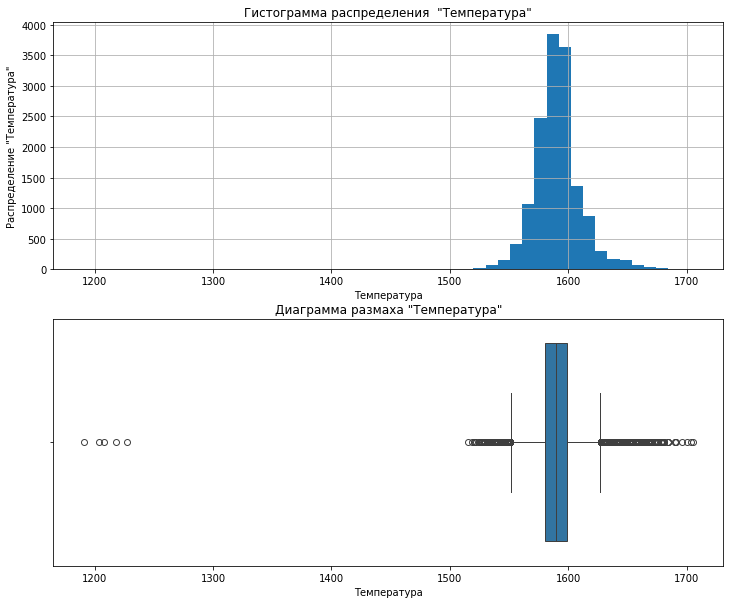

In [48]:
hist_boxplot(temp['Температура'], 'Температура', 50)

Из графиков видно, что есть несколько аномальных значений - температура менее 1300 градусов. Это ниже температуры плавления материала. Их необходимо будет удалить. Медианное значение температуры составляет 1590 градусов. Большинство значений лежат в пределах от 1550 до 1650 градусов.

Объектом моделирования является конечная температра сплава в ковше, поэтому удалим все записи, в которых есть пропуски в параметре `Температура`, так как они не пригодятся для моделирования.

In [49]:
temp.dropna(inplace=True)
print("Размерность датафрейма после удаления пропусков: ", temp.shape)

Размерность датафрейма после удаления пропусков:  (14665, 3)


Посчитаем количество измерений температы в каждой партии. Для пресказания нам необходимо, чтобы было хотя бы два измерения температуры. Удалим партии, в которых только одно измерение температруы. Для этого сначала сгруппируем данные по партиям.

In [50]:
temp_measure = temp.groupby('key').agg('count')
# выведм несколько партий в которых только одно измерение температуры
temp_measure.tail()

,Время замера,Температура
key,,
3237,1,1
3238,1,1
3239,1,1
3240,1,1
3241,1,1


Отберем те партии, где количество измерений температуры равняется 1. Эти партии необходимо будет удалить

In [51]:
key_to_remove = temp_measure[temp_measure['Температура']==1].index
print('Партии для удаления:\n', key_to_remove, '\n')
# удалим партии непригодные для моделирования
temp = temp[~temp['key'].isin(key_to_remove)]
print('Размерность датафрейма после удаления партий с единичным измерением температуры:', temp.shape)

Партии для удаления:
 Int64Index([ 195,  279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507,
            ...
            3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241],
           dtype='int64', name='key', length=741) 

Размерность датафрейма после удаления партий с единичным измерением температуры: (13924, 3)


Также необходимо исключить из рассмотрения те партии, где температура сплава была ниже 1400 градусов - это явные аномалии, непригодные для моделирования.

In [52]:
print ('Количество партий, в которых замеры температуры были ниже 1400:', temp[temp['Температура'] < 1400]['key'].count())
temp = temp[temp['Температура'] >= 1400]
print ('Размерность датафрейма после удаления аномальных значений температуры:', temp.shape)

Количество партий, в которых замеры температуры были ниже 1400: 4
Размерность датафрейма после удаления аномальных значений температуры: (13920, 3)


Составим сводную таблицу, где объеденим время начала и конца замера, а также начальную и конечную температуру.

In [53]:
temp_agg = temp.pivot_table(index='key', values=['Время замера', 'Температура'], aggfunc={'first', 'last'})
temp_agg.columns = ['Время начала замера', 'Время конца замера', 'Температура в начале', 'Температура в конце']
temp_agg['Интервал замера'] = (temp_agg['Время конца замера'] - temp_agg['Время начала замера']).astype('timedelta64[s]')
temp_agg['Интервал замера'] = temp_agg['Интервал замера'].astype('int64')
temp_agg

,Время начала замера,Время конца замера,Температура в начале,Температура в конце,Интервал замера
key,,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536
...,...,...,...,...,...
2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0,1380
2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0,1705
2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0,962


Конечная `Температура` является целевым признаком, который необходимо будет предсказать. Проверим, нет ли в сгруппированных данных дубликатов или пропусков.

In [54]:
print ('Количество полных дубликатов: ', temp_agg.duplicated().sum())

Количество полных дубликатов:  0


In [55]:
print ('Количество пропусков:')
temp_agg.isna().sum()

Количество пропусков:


Время начала замера     0
Время конца замера      0
Температура в начале    0
Температура в конце     0
Интервал замера         0
dtype: int64

Построим распределение параметра `Интервал замера`, чтобы проверить, нет ли аномальных значений по времени замера.

In [56]:
temp_agg['Интервал замера'].describe()

count     2475.000000
mean      2279.871111
std       1373.958293
min        270.000000
25%       1544.500000
50%       2006.000000
75%       2738.500000
max      23674.000000
Name: Интервал замера, dtype: float64

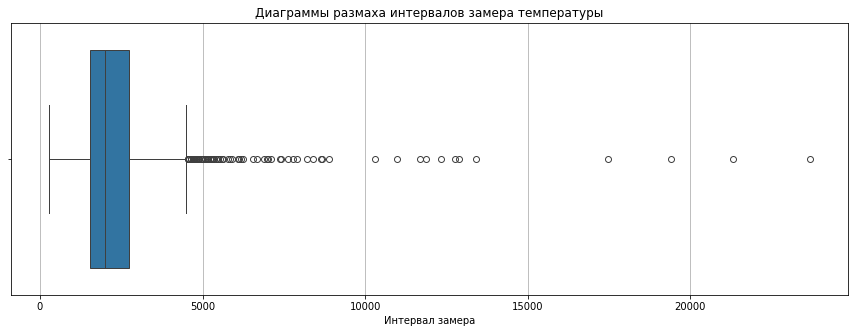

In [57]:
plt.figure(figsize=(15,5))
plt.grid(True)
sns.boxplot(temp_agg, x='Интервал замера', orient='h')
plt.title('Диаграммы размаха интервалов замера температуры')
plt.xlabel('Интервал замера');

**Выводы:**
- Средняя температура сплава около 1590 градусов.
- Были обработаны аномальные значения: удалены все значения с температурой сплава ниже 1400, а также все партии где был только один замер температуры (для моделирования необходимо минимум два).
- В исходных данных было 3427 пропусков, они были удалены.
- В сводной таблице были выделены начальная и конечная температура сплава для каждой партии, а также время начала и конца замера. `Температура в конце` является целевым признаком для моделирования, который необходимо будет предсказать.
- `Температура в начале` является входным признаком для моделирования. Промежуточные значения температур для моделирования не нужны.
- Из анализа `Интервала замера` можно сказать, что в среднем время между первым и последним замером температуры составляет 2000 секунд. Есть аномальные значение, где `Интервал замера` свыше 15 000 секунд.

### Данные о проволочных материалах (объём)
Выведем несколько случайных строк датафрейма.

In [58]:
wire_volume.sample(5, random_state=RANDOM_STATE)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1593,1673,115.127998,180.236161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2447,2574,141.173752,NaN,NaN,NaN,NaN,15.169441,NaN,NaN,NaN
925,985,153.223190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
713,760,125.330391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335,362,115.268402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
print('Количество полных дубликатов:', wire_volume.duplicated().sum())

Количество полных дубликатов: 0


Построим гистограммы распределения и диаграммы размаха для материало `Wire 1`...`Wire 2`.

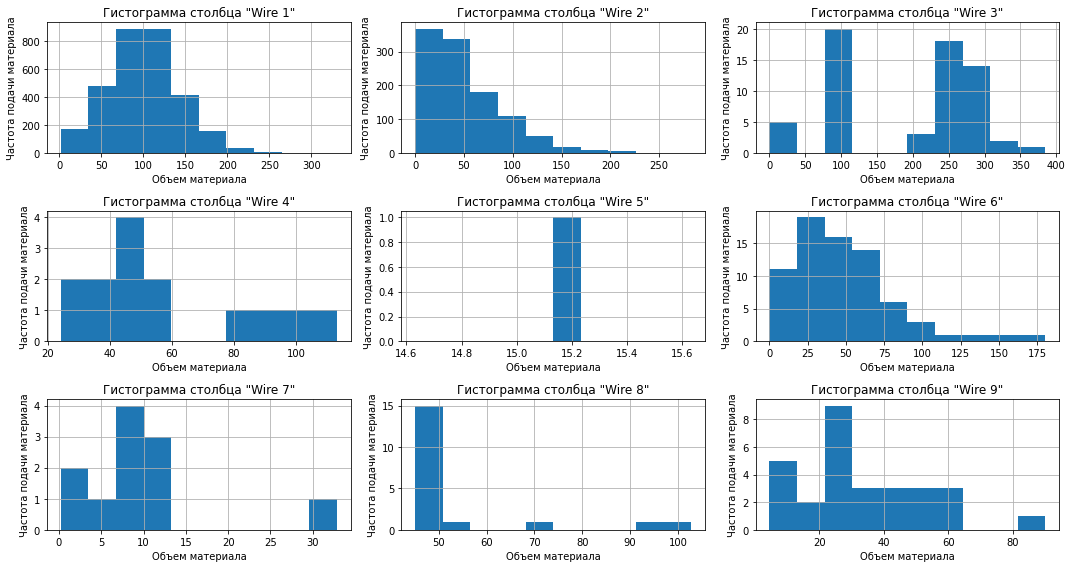

In [60]:
fig, axes = plt.subplots(3,3, figsize=(15,8))
axe = axes.ravel()
for i, col in enumerate(wire_volume.drop('key', axis=1).columns):
    axe[i].set_title(f'Гистограмма столбца "{col}"')
    axe[i].set_xlabel('Объем материала')
    axe[i].set_ylabel('Частота подачи материала')
    wire_volume[col].hist(bins=10, ax=axe[i])
    plt.tight_layout()

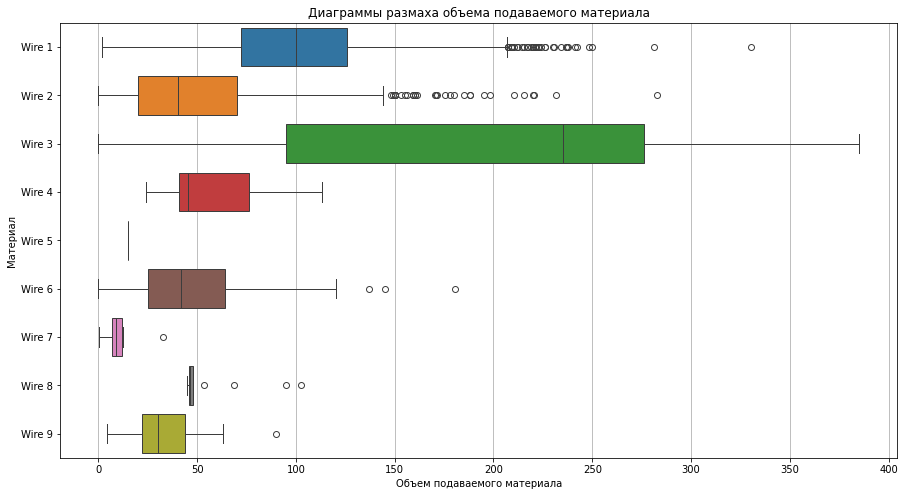

In [61]:
plt.figure(figsize=(15,8))
plt.grid(True)
sns.boxplot(wire_volume.drop('key', axis=1), orient='h')
plt.title('Диаграммы размаха объема подаваемого материала')
plt.xlabel('Объем подаваемого материала')
plt.ylabel('Материал');

Из гистограмм распределения видно, что наиболее часто используют материалы `Wire 1` и `Wire 2`. Материал `Wire 5` добавляли только один раз. Из гистограмм размаха видно, что в некоторых материалах есть выбросы по объему.

Проссумируем объемы проволочных материалов по каждой партии и посмотрим, как распределяются суммарные объемы подаваемого материала по партиям.

In [62]:
wire_volume['summ_wire'] = wire_volume.drop('key', axis=1).sum(axis=1)
wire_volume.sort_values(by='summ_wire', ascending=False).head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,summ_wire
2381,2508,175.637275,219.866410,268.348081,NaN,NaN,NaN,NaN,NaN,NaN,663.851766
2374,2501,172.754410,198.452789,254.462219,NaN,NaN,NaN,NaN,NaN,NaN,625.669418
2759,2912,190.095352,80.346243,327.233753,NaN,NaN,NaN,NaN,NaN,NaN,597.675348
1750,1840,200.210403,80.135117,288.432144,NaN,NaN,NaN,NaN,NaN,NaN,568.777664
1825,1915,161.091842,22.137440,385.008668,NaN,NaN,NaN,NaN,NaN,NaN,568.237950


Выведем на графике Топ-10 сплавов с наибольшим количеством добавок.

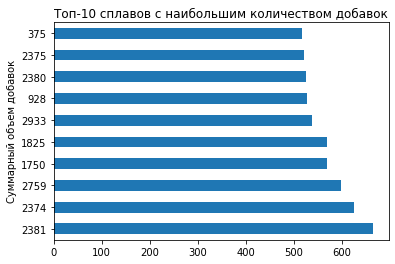

In [63]:
wire_volume['summ_wire'].sort_values(ascending=False).head(10).plot(kind='barh', 
                                                                        title='Топ-10 сплавов с наибольшим количеством добавок',
                                                                        xlabel='Суммарный объем добавок',
                                                                        ylabel='Номер сплава');

Наибольшее количество проволочного материала было давлено в сплавы `2381` и `2374` - свыше 1200 м3.

**Вывод:** 
- Полных дубликатов в данных нет.
- Есть пропуски, кторые необходимо будет заполнить 0 в дальнейшем.
- Наиболее часто в качестве добавки используют материалы `Wire 1` и `Wire 2`.
- Материал `Wire 5` добавляли в сплав всего один раз.
- Больше всего материала добавили в сплавы `2381` и `2374` - свыше 1200, в остальных сплавах суммарный объем добавок не превышает 1200 м3.

### Данные о проволочных материалах (время)
Приведем данные о времени подачи материала к корректному формату `datetime64`.

In [64]:
for name_column in wire_time.drop('key', axis=1).columns:
    wire_time[name_column] = pd.to_datetime(wire_time[name_column])

Выведем первые строки датафрейма.

In [65]:
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Сгруппируем данные по партиям. Заменим пропуски в дате на `NaT`.

In [66]:
wire_time_agg = wire_time.groupby('key').agg('first')
wire_time_agg = wire_time_agg.apply(lambda x: x.fillna(pd.NaT), axis=0)

Выделим первую дату подачи материала и последнюю дату подачи материала.

In [67]:
wire_time_agg['first_date'] = wire_time_agg.min(axis=1)
wire_time_agg['last_date'] = wire_time_agg.max(axis=1)

Рассчитаем `Интервал подачи материала` между первой датой подачи и последней датой подачи.

In [68]:
wire_time_agg['Интервал подачи материала'] = (wire_time_agg['last_date'] - wire_time_agg['first_date']).astype('timedelta64[s]')
wire_time_agg['Интервал подачи материала'] = (wire_time_agg['Интервал подачи материала']).astype('int64')
wire_time_agg.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,first_date,last_date,Интервал подачи материала
key,,,,,,,,,,,,
1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:06:19,2019-05-03 11:06:19,0
2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:36:50,2019-05-03 11:36:50,0
3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:11:46,2019-05-03 12:11:46,0
4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:43:22,2019-05-03 12:43:22,0
5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:15:34,2019-05-03 13:20:44,310


Проанализируем данные о времени подачи проволочного материала. Построим гистограммы распределения и диаграммы размаха.

Статистические данные по столбцу "Интервал подачи материала"


count    3081.000000
mean      214.519312
std       396.131967
min         0.000000
25%         0.000000
50%         0.000000
75%       401.000000
max      5937.000000
Name: Интервал подачи материала, dtype: float64

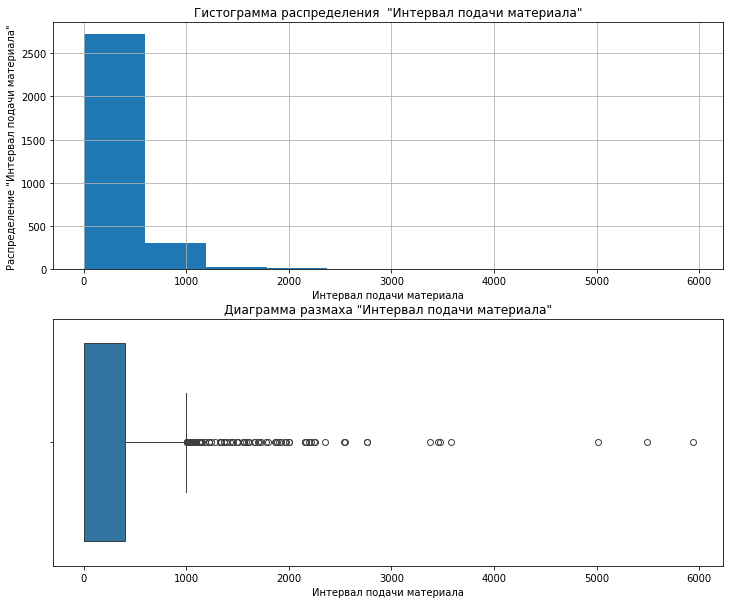

In [69]:
hist_boxplot(wire_time_agg['Интервал подачи материала'], 'Интервал подачи материала')

**Вывод:** Интервал времени между первой и последней подачей проволочного материала меньше, чем для сыпучего, и составляет 214 секунд. Есть несколько измерений равных 0, это значит, что была только одна подача проволочного материала. Есть несколько единичных выбросов, когда интервал между первой и последней подачей материала был более 4000 секунд. Максимальный интервал составил 5937 секунд. Длительные промежутки времени могут быть обусловлены особенностями технологического процесса. Супервыбросов, когда интервал составлял бы несколько суток, нет.

### Вывод
Был проведен исследовательский анализ всех предоставленных данных.
1. **Данные об электродах.** были удалены супервыбросы в параметре `Реактивная мощность` (отрицательное значение мощности). Были добавлены новые признаки: `Полная мощность` и `Время работы дуги`. Для новых признаков также были построены гистограммы рампределения и диаграммы размаха. Была рассчитана суммарная `Полная мощность` и `Время работы дуги`. Эти данные будут использоваться в дальнейшем как входные признаки.


2. **Данные о сыпучих материалах.** Были построены гистограммы распределения частоты подачи каждого вида материала, а также диаграммы размаха. Некоторые материалы вводились в сплавы всего один-два раза, их можно будет удалить из дальнейшего рассмотрения. Есть единичные выбросы когда объем поданного материала был выше 1750 м3. Также был введен новый признак - суммарный объем добавок для каждой партии.


3. **Данные о времени подачи сыпучих материалов.** Для каждой партии было выделено время первой и последней подачи материала, а затем рассчитан интервал между ними. В данных было несколько единичных выбросов, когда время между первой и последней подачей материала составляло более двух часов. Однако, длительные промежутки времени могут быть обусловлены особенностями технологического процесса, поэтому было принято решение их оставить. Данные о времени не будут использоваться для дальнейшего моделирования.


4. **Данные о продувке сплава газом.** Средний объем подаваеомого газа составляет около 11 м3. В даных есть выбросы - объем подаваемого газа более 25 м3. Максимальное значение подаваемого газа составило почти 78 м3. Большой объем подаваемого газа может быть обусловлен особенностями технологического процесса, поэтому было принято решение не удалять такие значения.


5. **Результаты измерений температуры.** Средняя температура сплава составляет около 1590 градусов. Были обработаны аномальные значения: удалены все значения с температурой сплава ниже 1400, а также все партии где был только один замер температуры (для моделирования необходимо минимум два). В исходных данных было 3427 пропусков, они были удалены. В сводной таблице были выделены начальная и конечная температура сплава для каждой партии, а также время начала и конца замера. `Температура в конце` - это целевой признак для моделирования. `Температура в начале` является входным признаком для моделирования. Промежуточные значения температур для моделирования не нужны.


6. **Данные о проволочных материалах.** Выводы аналогичные данным о сыпучих материалах. Супервыбросов или аномалий в данных не наблюдалось.


7. **Данные о времени подачи проволочных материалов.** Выводы аналогичные данным о времени подачи сыпучих материалов. Интервал времени между первой и последней подачей проволочного материала меньше, чем для сыпучего. Данные о времени не будут использоваться для дальнейшего моделирования.

<a id='3'></a>
## Объединение данных
Объединим таблицы методом `inner` таким образом, чтобы в итоговом датафрейме остались только те партии, которые были во всех датафреймах. Для объединения возьмем датафреймы `temp_agg`, `arc_agg`, `bulk_volume`, `wire_volume` и `gas`. Датафреймы, содержащие информацию о времени подачи материала, не будем включать в итоговую таблицу.

In [70]:
df_general = temp_agg.merge(arc_agg, on='key', how='inner')
df_general = df_general.merge(bulk_volume, on='key', how='inner')
df_general = df_general.merge(wire_volume, on='key', how='inner')
df_general = df_general.merge(gas, on='key', how='inner')

Удалим колонки, которые будут не нужны для дальнешего моделирования.

In [71]:
df_general.drop(['key', 'Время начала замера', 'Время конца замера'], axis=1, inplace=True)

Выведем несколько строк итогового датафрейма, получившегося после объединения.

In [72]:
df_general

,Температура в начале,Температура в конце,Интервал замера,Активная мощность,Время работы дуги,Полная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,summ_wire,Газ 1
0,1571.0,1613.0,1714,3.036730,1098,3.718736,2.142821,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998,29.749986
1,1581.0,1602.0,1265,2.139408,811,2.588349,1.453357,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315,12.555561
2,1596.0,1599.0,1753,4.063641,655,5.019223,2.937457,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,28.554793
3,1601.0,1625.0,1220,2.706489,741,3.400038,2.056992,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515,18.841219
4,1576.0,1602.0,1536,2.252950,869,2.816980,1.687991,NaN,NaN,NaN,...,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.352796,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,1570.0,1591.0,1380,3.168133,723,3.868721,2.210936,NaN,NaN,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.150879,7.125735
2324,1554.0,1591.0,1705,4.174918,940,5.070316,2.872031,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.179527,9.412616
2325,1571.0,1589.0,962,3.605239,569,4.360918,2.452092,NaN,NaN,NaN,...,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.134723,6.271699
2326,1591.0,1594.0,1520,3.202310,750,3.909917,2.239820,NaN,NaN,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.110717,14.953657


В итоговом датафрейме 2328 строк и 34 колонки. Выведем общею информацию о датафрейме.

In [73]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Температура в начале  2328 non-null   float64
 1   Температура в конце   2328 non-null   float64
 2   Интервал замера       2328 non-null   int64  
 3   Активная мощность     2328 non-null   float64
 4   Время работы дуги     2328 non-null   int64  
 5   Полная мощность       2328 non-null   float64
 6   Реактивная мощность   2328 non-null   float64
 7   Bulk 1                199 non-null    float64
 8   Bulk 2                13 non-null     float64
 9   Bulk 3                960 non-null    float64
 10  Bulk 4                812 non-null    float64
 11  Bulk 5                53 non-null     float64
 12  Bulk 6                437 non-null    float64
 13  Bulk 7                13 non-null     float64
 14  Bulk 8                1 non-null      float64
 15  Bulk 9               

В целевом признаке `Температура` пропусков нет. В данных есть пропуски во входных признаках, их мы заполним в дальнейшем в пайплайне. Посмотрим есть ли в данных полные дубликаты.

In [74]:
print('Количество дубликатов:', df_general.duplicated().sum())

Количество дубликатов: 0


<a id='4'></a>
## Исследовательский анализ объединенного датафрейма
Рассчитаем корреляцию между всеми признаками для объединенного датафрейма.

In [75]:
corr_matrix = df_general.corr(method='pearson')

Построим матрицу корреляции для всех признаков.

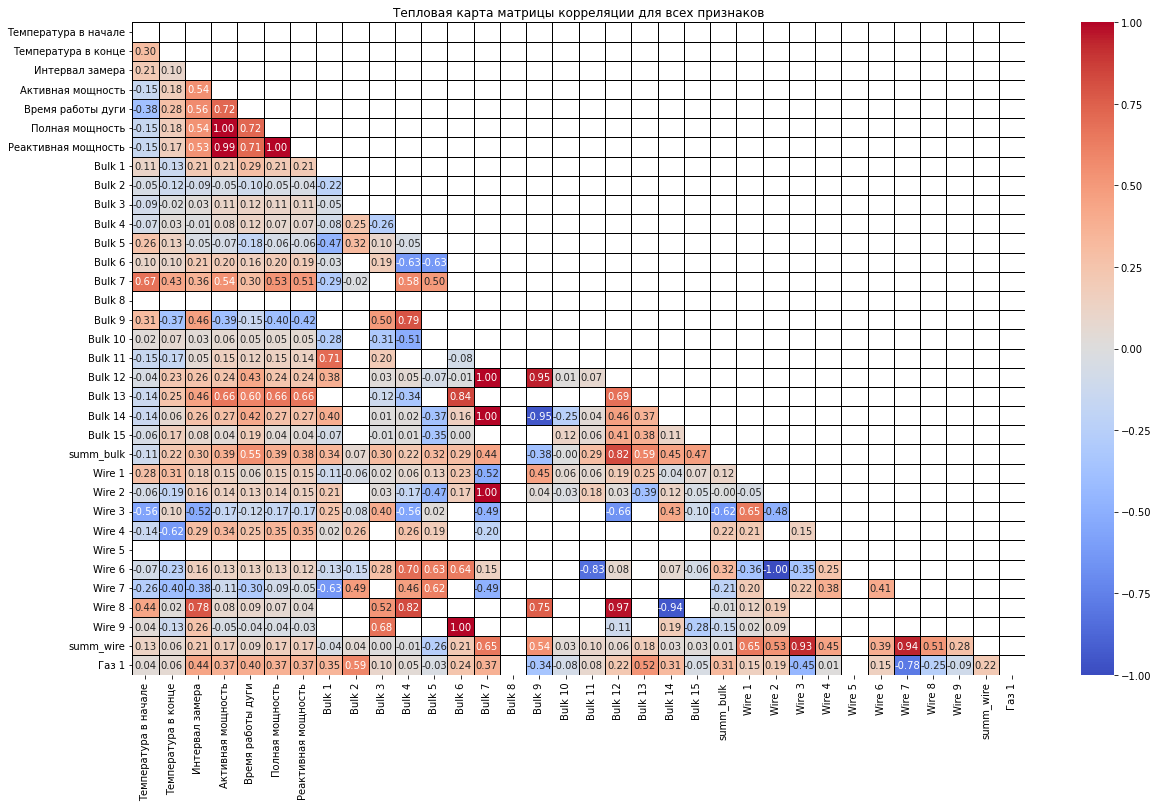

In [76]:
fig, ax = plt.subplots(figsize=(20, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, square=False, mask=mask, linewidths=.5, linecolor='black', fmt='.2f')
plt.title('Тепловая карта матрицы корреляции для всех признаков');

Между признаками `Рективная мощность`, `Активная мощность` и `Полная мощность` наблюдается мультиколлениарность. Признаки `Рективная мощность` и `Активная мощность` можно не включать в дальнешее моделирование. Также можно удалить признаки `Bulk 8` и `Wire 5`, так как в этих признаках так много пропусков, что невозможно установить их корреляцию с целевым признаком. 

- Высокая корреляция наблюдается между признаками `Время работы дуги` и  `Активная мощность` (0.72), `Интервал замера` и `Wire 8` (0.78).
- Высокая корреляция также есть между некоторыми видами сыпучих и проволочных материалов:
    - `Bulk 4` и `Wire 8` (0.82);
    - `Bulk 6` и `Wire 9` (1.00);
    - `Bulk 7` и `Wire 2`, `Bulk 14`, `Bulk 12`(1.00);
    - `Bulk 9` и `Bulk 12`(0.95);
    - `Bulk 11` и `Wire 6`(-0.83);
    - `Bulk 12` и `Wire 8`(0.97);
    - `Wire 2` и `Wire 6`(-1.00).

Построим отдельно диаграмму корреляции между целевым признаком `Температура в конце` и входными признаками.

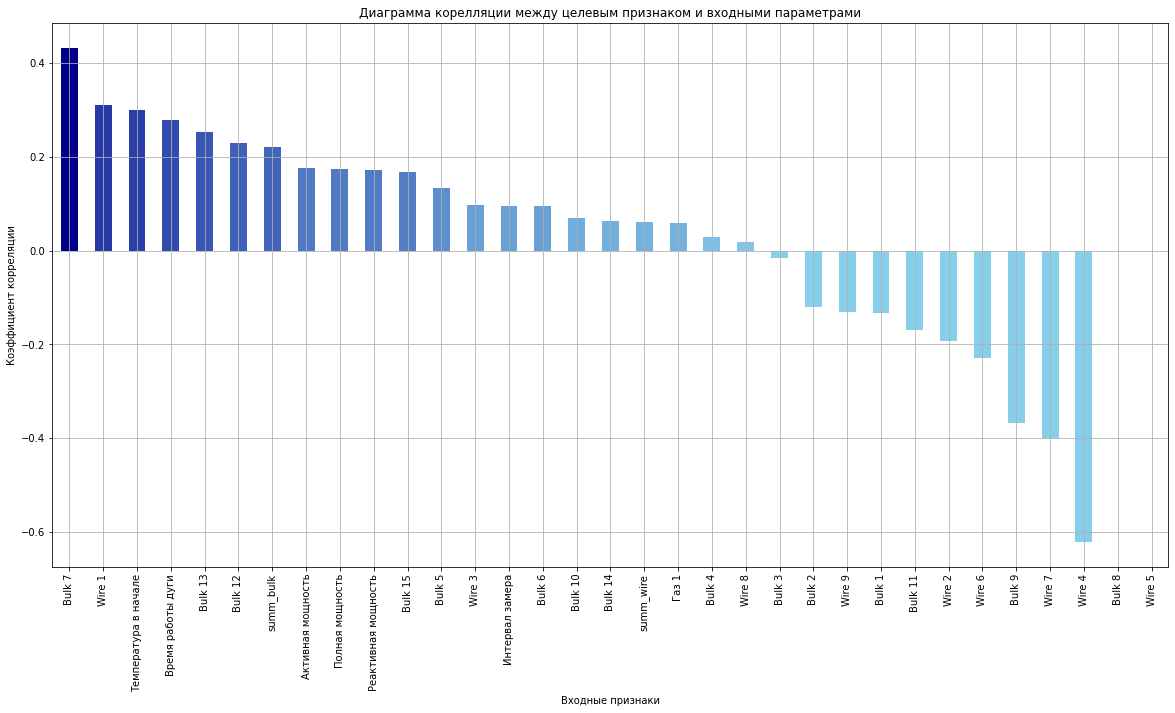

In [77]:
corr = corr_matrix['Температура в конце'].drop('Температура в конце').sort_values(ascending=False)
# Создаем цветовую карту (градиент)
cmap = mcolors.LinearSegmentedColormap.from_list("my_blue_cmap",
[
    [0.529, 0.808, 0.922, 1],
    [0.0, 0.0, 0.545, 1]
])
# Создаем столбчатую диаграмму с градиентом
max_corr = corr.max()
# Выводим диаграмму
corr.plot(kind='bar', color=cmap(corr/max_corr), grid=True, figsize=(20,10))
plt.title('Диаграмма корелляции между целевым признаком и входными параметрами')
plt.xlabel('Входные признаки')
plt.ylabel('Коэффициент корреляции');

Наибольшая положительная корреляция наблюдается между целевым признаком `Температура в конце` и признаком - объем сыпучего материала `Bulk 7` (0.43). Наибольшая отрицательная корреляция - между целевым признаком и объемом проволочного материала `Wire 7` (-0.4) и `Wire 4` (-0.62).

**Вывод:**
1. Между признаками `Рективная мощность`, `Активная мощность` и `Полная мощность` наблюдается мультиколлениарность их необходимо удалить.
2. Также можно удалить признаки `Bulk 8` и `Wire 5`, так как в этих признаках так много пропусков, что невозможно установить их корреляцию с целевым признаком.
3. Высокая корреляция также есть между некоторыми видами сыпучих и проволочных материалов.
4. Наибольшая положительная корреляция наблюдается между целевым признаком `Температура в конце` и признаком - объем сыпучего материала `Bulk 7` (0.43).
5. Наибольшая отрицательная корреляция - между целевым признаком и объемом проволочного материала `Wire 7` (-0.4) и `Wire 4` (-0.62).

<a id='5'></a>
## Подготовка данных
Отберем входные признаки `X`, удалив лишние признаки, описанные на предыдущем этапе. Выделим целевую переменную `Y`.

In [78]:
X = df_general.drop(['Активная мощность', 'Реактивная мощность', 'Bulk 8', 'Wire 5', 'Температура в конце'], axis=1)
Y = df_general['Температура в конце']
# выведем первые строки датафрейма с входными признаками
X.head()

,Температура в начале,Интервал замера,Время работы дуги,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,summ_wire,Газ 1
0,1571.0,1714,1098,3.718736,NaN,NaN,NaN,43.0,NaN,NaN,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.059998,29.749986
1,1581.0,1265,811,2.588349,NaN,NaN,NaN,73.0,NaN,NaN,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.052315,12.555561
2,1596.0,1753,655,5.019223,NaN,NaN,NaN,34.0,NaN,NaN,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.160157,28.554793
3,1601.0,1220,741,3.400038,NaN,NaN,NaN,81.0,NaN,NaN,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.063515,18.841219
4,1576.0,1536,869,2.816980,NaN,NaN,NaN,78.0,NaN,NaN,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,98.352796,5.413692


Разобъем данные на тренировочную и тестовую выборку в отношении 1:4.

In [79]:
X_train, X_test, y_train, y_test= train_test_split(X,
                                                   Y, 
                                                   test_size=TEST_SIZE, 
                                                   random_state=RANDOM_STATE)

In [80]:
print('Размерность тренировочной выборки:', X_train.shape)
print('Размерность тестовой выборки:', X_test.shape)

Размерность тренировочной выборки: (1746, 29)
Размерность тестовой выборки: (582, 29)


В данных есть пропуски - пропущенные значение, когда материал не подавался. Заполним пропуски в данных 0 с помощью метода `SimpleImputer`. 

In [81]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

Обратимся к методу `get_feature_names_out()`, который вернет наименования столбцов. Это пригодится в случае анализа важности признаков.

In [82]:
features_names = imputer.get_feature_names_out()

In [83]:
X_train = pd.DataFrame(X_train, columns=features_names)
X_test = pd.DataFrame(X_test, columns=features_names)

**Выводы:** Были отобраны входные признаки, которые в дальнейшем будут использоваться для обучения модели. Данные были разбиты на тренировочную и тестовую выборку в отношении 4:1. Пропуски в тренировочных и тестовых данных были заполнены с помощью метода `SimpleImputer`.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА</b></u></p>
отлично, идём дальше.

<a id='6'></a>
## Обучение моделей машинного обучения
### LinearRegression
Обучим модель линейной регрессии `LinearRegression()`. Перед этим подготовим данные. 

С помощью метода `StandardScaler()` проведем масштабирование данных.

In [84]:
scaler = StandardScaler()
X_train_scaler = pd.DataFrame(scaler.fit_transform(X_train))

Рассчитаем метрику `MAE` с помощью кросс-валидации `cross_val_score` на тренировочной выборке.

In [85]:
%%time
model_lr = LinearRegression()
result = cross_val_score(model_lr, X_train_scaler, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
MAE_lr = round((-1)*result, 2)
print('Метрика модели линейной регрессии на тренировочной выборке:', MAE_lr)

Метрика модели линейной регрессии на тренировочной выборке: 6.11
CPU times: user 528 ms, sys: 549 ms, total: 1.08 s
Wall time: 1.03 s


**Вывод:** Данные предварительно были отмасштабированы с помощью метода `StandardScaler()`. Значение метрики `MAE` модели `LinearRegression()` на тренировочных данных 5.91.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА</b></u></p>
а у меня получилось астрономическое число)) Это из-за того, что много редких событий. Т.е. есть присадки, в которых долько несколько наблюдений. С факторами с редкими событиями лучше как-то расправляться заранее)

### RandomForestRegressor
Обучим модель `RandomForestRegressor()`.

In [86]:
model_random_forest = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

Соствим словарь гипермараметров, которые переберем с помощью кросс-валидации `RandomizedSearchCV`.

In [87]:
parameters_random_forest = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None] + [i for i in range(2,5)],
    'min_samples_split':range(2,5),
    'max_features': ('sqrt', 'log2', 1.0)
}

Передадим в функцию для кросс-валидации `RandomizedSearchCV` модель и словарь гиперпараметров, зададим метрику, по которой будем оценивать качество модели.

In [88]:
random_search_1 = RandomizedSearchCV(
    model_random_forest,
    parameters_random_forest,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

Обучим модель на тренировочных данных.

In [89]:
%%time
random_search_1.fit(X_train, y_train)

CPU times: user 31.3 s, sys: 0 ns, total: 31.3 s
Wall time: 31.4 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1,
                                                   random_state=40624),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 2, 3, 4],
                                        'max_features': ('sqrt', 'log2', 1.0),
                                        'min_samples_split': range(2, 5),
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=40624, scoring='neg_mean_absolute_error')

Сохраним лучшую модель и выведем параметры лучшей модели.

In [90]:
best_random_forest = random_search_1.best_estimator_

In [91]:
print('Параметры лучшей модели:')
random_search_1.best_params_

Параметры лучшей модели:


{'n_estimators': 300,
 'min_samples_split': 4,
 'max_features': 1.0,
 'max_depth': None}

Выведем метрику лучшей модели, полученной с помощтю кросс-валидации, на тренировочных данных.

In [92]:
MAE_random_forest = round((-1)*(random_search_1.best_score_),2)
print('Метрика модели случайного леса на тренировочной выборке:', MAE_random_forest)

Метрика модели случайного леса на тренировочной выборке: 6.22


**Выводы:** 

Параметры лучшей модели:
- `n_estimators`: 300;
- `min_samples_split`: 4;
- `max_features`: 1.0;
- `max_depth`: None.

Метрика `MAE` лучшей модели на тренировочной выборке: 6.19

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА</b></u></p>
второй сделан)

### CatBoostRegressor
Обучим модель `CatBoostRegressor()`.

In [93]:
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, loss_function='MAE', verbose=False)

Соствим словарь гипермараметров, которые переберем с помощью кросс-валидации `RandomizedSearchCV`.

In [94]:
parameters_catboost = [
    {
        'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.02],
        'iterations': [100, 200, 300],
        'depth': range(2,10)
    }
]

Передадим в функцию для кросс-валидации `RandomizedSearchCV` модель и словарь гиперпараметров, зададим метрику, по которой будем оценивать качество модели.

In [95]:
random_search_2 = RandomizedSearchCV(
    model_catboost,
    parameters_catboost,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

Обучим модель на тренировочных данных.

In [96]:
%%time
random_search_2.fit(X_train, y_train)

CPU times: user 47.2 s, sys: 577 ms, total: 47.7 s
Wall time: 1min 10s


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f6fef50a940>,
                   n_jobs=-1,
                   param_distributions=[{'depth': range(2, 10),
                                         'iterations': [100, 200, 300],
                                         'learning_rate': [0.3, 0.2, 0.1, 0.01,
                                                           0.02]}],
                   random_state=40624, scoring='neg_mean_absolute_error')

Сохраним лучшую модель и выведем ее параметры.

In [97]:
best_catboost = random_search_2.best_estimator_

In [98]:
print ('Параметры лучшей модели:')
random_search_2.best_params_

Параметры лучшей модели:


{'learning_rate': 0.1, 'iterations': 300, 'depth': 3}

Выведем метрику `MAE` лучшей модели на тренировочных данных.

In [99]:
MAE_catboost = round((-1)*random_search_2.best_score_, 3)
print ('Метрика лучшей модели CatBoostRegressor на тренировочной выборке:', MAE_catboost)

Метрика лучшей модели CatBoostRegressor на тренировочной выборке: 5.871


**Выводы:** 

Параметры лучшей модели:
- `learning_rate`: 0.1;
- `iterations`: 300;
- `depth`: 3.

Метрика `MAE` лучшей модели на тренировочной выборке: 5.89.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА</b></u></p>
👍

<a id='7'></a>
## Выбор лучшей модели
Объединим результаты обучения в одну таблицу и проанализируем их.

In [100]:
models = pd.DataFrame({
    'name_model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
    'parameters_best_model': ['', random_search_1.best_params_, random_search_2.best_params_],
    'MAE_train': [MAE_lr, MAE_random_forest, MAE_catboost]
})

In [101]:
pd.set_option('display.max_colwidth', None)
models

,name_model,parameters_best_model,MAE_train
0,LinearRegression,,6.110
1,RandomForestRegressor,"{'n_estimators': 300, 'min_samples_split': 4, 'max_features': 1.0, 'max_depth': None}",6.220
2,CatBoostRegressor,"{'learning_rate': 0.1, 'iterations': 300, 'depth': 3}",5.871


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА</b></u></p>
итоговая табличка - молодец!

Лучшая метрика `MAE` на тренировочных данных получилась у модели `CatBoostRegressor` с параметрами: `learning_rate`: 0.1, `iterations`: 300, `depth`: 3. Худший результат показала модель `RandomForestRegressor`: метрика `MAE` равняется 6.19.

Проанализируем важность признаков, которую присваивает модель `CatBoostRegressor`. Для того чтобы сделать выводы о том, какие признаки влияют на нашу модель больше всего, построим SHAP-диаграммы

In [102]:
# предадим TreeExplainer лучшую модель и тренировочную выборку
explainer = shap.TreeExplainer(best_catboost, X_train)
# найдем SHAP-значение
shap_values = explainer(X_train)

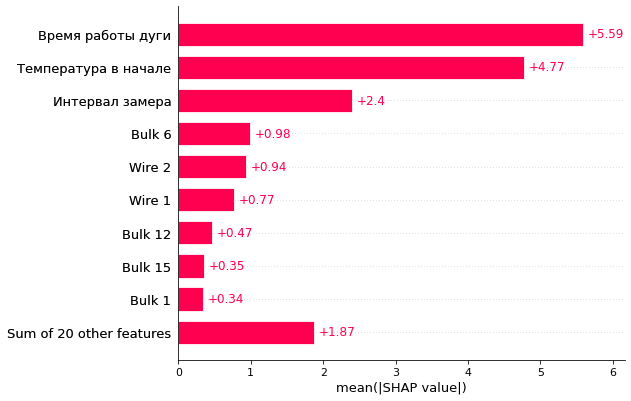

In [103]:
shap.plots.bar(shap_values, max_display=10) 

Из полученной диаграммы видно, что наибольшей важностью обладают признаки: `Время работы дуги`, `Температура в начале`, `Интервал замера`, а также объем добавленного проволочного материала `Wire 1` и `Wire 2`.

Чтобы получить общее представление о том, какие функции наиболее важны для модели, мы можем построить график значений SHAP для каждого признака для каждого объекта. На приведенном ниже графике объекты сортируются по сумме SHAP-значений по всем выборкам. Цвет представляет значение объекта (красный - высокий, синий - низкий).

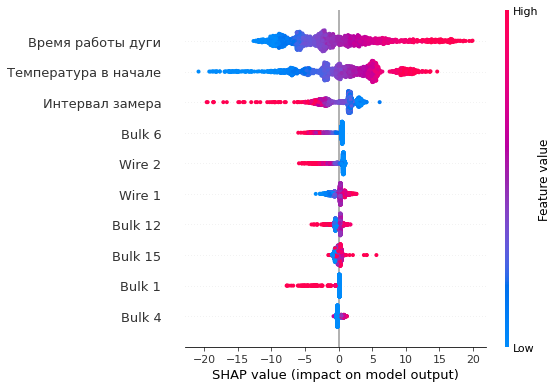

In [104]:
shap.summary_plot(shap_values, X_train, max_display=10) 

Видим, что высокое значение `Времени работы дуги` увеличивает прогнозируемое значение температуры, тогда как низкое значение этого признака, наоборот. снижает значение температуры. Высокое значение `Температуры (сплава) в начале` также увеличивает значение температуры в конце, тогда как большие промежутки `Интервала времени замера` между начальной и конечной температурой, наоборот, снижают значение целевой переменной.

Из добавок, которые вводятся в сплав, наибольшее влияение на предсказание оказывает проволочный материал `Wire 1`: при увеличении объема этого материала в сплаве температура сплава растет, при уменьшении - снижается. `Wire 2`, наоборот, снижает конечную температуру сплава при увеличении его объема.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА</b></u></p>хорошо, что используешь этот инструмент. На начальном этапе мы можем нагенерить множество разных фич, в том чтисле и лишних. И вот этот инструмент, вкупе с анализом мультиколлинеарности позволяет избавляться от "балласта"). И этот баллст можно исключить и перестроить модель. Метрика не должна силно измениться. 

In [105]:
predictions = best_catboost.predict(X_test)
print('Метрика лучшей модели на тестовых данных:', mean_absolute_error(y_test, predictions))

Метрика лучшей модели на тестовых данных: 5.745971325766638


Метрика `MAE` показывает среднюю разницу между предсказанными значениями и фактическими значениями. Значит, предсказанные с помощью модели значения температуры отличаются от фактических приблизительно на 5.77 градуса. Это меньше требуемого уровня точности `MAE` < 6.8. Значит, полученная модель удовлетворяет требованиям заказчика.

Проверим адекватность модели, сравнив ее с моделью `DummyRegressor`, которая всегда предсказывает среднее значение температуры.

In [106]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
predictions_dummy = dummy.predict(X_test)
print('Метрика дамми-модели на тестовых данных:', mean_absolute_error(y_test, predictions_dummy))

Метрика дамми-модели на тестовых данных: 8.267706648087142


Метрика `MAE` на константной модели равняется 8.26. Это значит, что фактическое значение температуры приблизительно на 8.26 градусов отличается от просто среднего значения по выборке. Значит, полученная модель в среднем предсказывает значения лучше, чем дамми-модель. Такую модель можно использовать в работе. 

<a id='1'></a>
## Общий вывод и рекомендации заказчику
Для исследования комбинат `Стальная птица` предоставил следующие данные.

- `data_temp_new.csv` — результаты измерения температуры;
- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time _new.csv` — данные проволочных материалах (время);
- `data_gas_new.csv` — данные о продувке сплава газом.

Всего для работы были предоставлены 7 датафреймов, которые содержат данные об электродах, объеме и времени подачи сыпучих и проволочных материалов, данные о продувке сплава газом и результаты измерения температуры. Первичный анализ показал, что данные соответсвуют описанию. В некоторых дататфреймах пропущенные значения составлют значительную часть от всех данных, такие пропуски были обработаны или удалены.

Был проведен исследовательский анализ всех предоставленных данных.
1. **Данные об электродах.** были удалены супервыбросы в параметре `Реактивная мощность` (отрицательное значение мощности). Были добавлены новые признаки: `Полная мощность` и `Время работы дуги`. Эти признаки использовались в дальнейшем как входные признаки.

2. **Данные о сыпучих и проволочных материалах.** Были построены гистограммы распределения частоты подачи каждого вида материала, а также диаграммы размаха. Некоторые материалы вводились в сплавы всего один-два раза, они были удалены, так как пропуски в них составили более 80%. Также был введен новый признак - суммарный объем добавок для каждой партии. Пропуски в объеме были заполнены 0, так как это значит, что материал не подавался. В данных были выбросы, однако они не были удалены.
3. **Данные о времени подачи сыпучих и проволочных материалов.** Для каждой партии было выделено время первой и последней подачи материала, а затем рассчитан интервал между ними. В данных было несколько единичных выбросов, когда время между первой и последней подачей материала составляло более двух часов. Однако, длительные промежутки времени могут быть обусловлены особенностями технологического процесса, поэтому было принято решение их оставить. Данные о времени не будут использоваться для дальнейшего моделирования.
4. **Данные о продувке сплава газом.** Средний объем подаваеомого газа составляет около 11 м3. В даных были выбросы - объем подаваемого газа более 25 м3. Максимальное значение подаваемого газа составило почти 78 м3. Большой объем подаваемого газа может быть обусловлен особенностями технологического процесса, поэтому было принято решение не удалять такие значения.
5. **Результаты измерений температуры.** Средняя температура сплава составляет около 1590 градусов. Были обработаны аномальные значения: удалены все значения с температурой сплава ниже 1400, а также все партии где был только один замер температуры (для моделирования необходимо минимум два). В исходных данных было 3427 пропусков, они были удалены. В сводной таблице были выделены начальная и конечная температура сплава для каждой партии, а также время начала и конца замера. `Температура в конце` - это целевой признак для моделирования. `Температура в начале` является входным признаком для моделирования. Промежуточные значения температур для моделирования не нужны. Был добавлен новый признак `Интервала замера` - время между первым и последним замером температуры. В среднем время между первым и последним замером температуры на партию составляет 2000 секунд. 

Затем все данные были объединены в общий датафрейм по общему полю `key`. Всего в объединенном датафрейме получилось 2328 строк и 34 столбца. Для объединенного датафрейма был проведен корреляционный анализ, по итогам которого были сделаны следующие выводы:
1. Между признаками `Рективная мощность`, `Активная мощность` и `Полная мощность` наблюдается мультиколлениарность, они были удалены.
2. Также были удалены признаки `Bulk 8` и `Wire 5`, так как в этих признаках много пропусков.
3. Высокая корреляция также наблюдалась между некоторыми видами сыпучих и проволочных материалов.
4. Наибольшая положительная корреляция наблюдалась между целевым признаком `Температура в конце` и признаком - объем сыпучего материала `Bulk 7` (0.43).

В результате были отобраны следующие входные признаки для дальнейшего моделирования.

In [107]:
list(X.columns)

['Температура в начале',
 'Интервал замера',
 'Время работы дуги',
 'Полная мощность',
 'Bulk 1',
 'Bulk 2',
 'Bulk 3',
 'Bulk 4',
 'Bulk 5',
 'Bulk 6',
 'Bulk 7',
 'Bulk 9',
 'Bulk 10',
 'Bulk 11',
 'Bulk 12',
 'Bulk 13',
 'Bulk 14',
 'Bulk 15',
 'summ_bulk',
 'Wire 1',
 'Wire 2',
 'Wire 3',
 'Wire 4',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9',
 'summ_wire',
 'Газ 1']

Данные были разбиты на тренировчоную и тестовую выборку в отношении 4:1. Были обучены три модели: `LinearRegression`, `RandomForestRegressor` и `CatBoostRegressor`. Результаты обучения были собраны в таблицу.

In [108]:
models

,name_model,parameters_best_model,MAE_train
0,LinearRegression,,6.110
1,RandomForestRegressor,"{'n_estimators': 300, 'min_samples_split': 4, 'max_features': 1.0, 'max_depth': None}",6.220
2,CatBoostRegressor,"{'learning_rate': 0.1, 'iterations': 300, 'depth': 3}",5.871


Лучшая метрика `MAE` на тренировочных данных получилась у модели `CatBoostRegressor` с параметрами: 
- `learning_rate`: 0.1,
- `iterations`: 300,
- `depth`: 3.

Метрика лучшей модели на тестовых данных составила: 5.77. Это меньше требуемого заказчиком уровня `MAE` < 6.8. Также была проверена адекватность модели, по сравнению ее с моделью `DummyRegressor`, которая всегда предсказывает среднее значение температуры. Полученную модель можно использовать в дальнейшей работе.

Также был проведен анализ важности признаков и построены SHAP-диаграммы. Наибольшей важностью для модели обладают признаки: `Время работы дуги`, `Температура в начале`, `Интервал замера`, а также объем добавленного проволочного материала `Wire 1` и `Wire 2`.

Высокое значение `Времени работы дуги` увеличивает прогнозируемое значение температуры, тогда как низкое значение этого признака, наоборот, снижает значение температуры. Высокое значение `Температуры (сплава) в начале` также увеличивает значение температуры в конце, тогда как большие промежутки `Интервала времени замера` между начальной и конечной температурой, наоборот, снижают значение целевой переменной.

Из добавок, которые вводятся в сплав, наибольшее влияение на предсказание оказывает проволочный материал `Wire 1`: при увеличении объема этого материала в сплаве температура сплава растет, при уменьшении - снижается. `Wire 2`, наоборот, снижает конечную температуру сплава при увеличении его объема.

Таким образом, была получена модель, которая с требуемой точностью предсказывает конечное значение температуры спалва в ковше. Задачей `Стальной птицы` было снижение затрат на электроэнергию с помощью более точного контроля температуры. Исходя из анализа важности признаков видно, что наибольший вклад в предсказание температуры вносят не легирующие добавки (проволочные и сыпучие материалы), десульфация или продувка газом, а время работы дуги электродов, начальная температура сплава и интервалы замеров. 

То есть для того, чтобы повысить точность температуры необходимо более тщательно контролировать и оптимизировать рабочий процесс: 
- контролировать температру сплава в начале процесса: можно уменьшать погрешность измерения температуры сплавов за счет модернизации оборудования;
- тщательнее следить за каждым процессом нагрева: время работы дуги является ключевым фактором, влияющим на конечную температуру, если дуга работает очень долго, значит проводится очень много циклов нагрева, которые, однако, не приводят к необходимой температуре;
- чаще проводить замеры температуры в процессе работы.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
Екатерина, однозначно сильная работа!!!<br>
Я бы привёл ещё такие эпитеты: смелый, аналитический, вдумчивый проект.<br>
Правда, было интерсно погружать в твои рассуждения и следить  за ними.<br>
C позиции логики построения модели - мне всё понятно.<br>
 
Всегда стараюсь на этом проекте сказать всем вот ещё что: цель заказчика - экономия энергоресурсов.<br>
И в этом проекте искали как раз способ точно предсказывать температуру. И круто использовали для этого весь арсенал<br>
А если рассудать с позиции такой: а что нужно сделать, чтобы снизить энергопотребление?<br>
Судя по модели, самым важным фактором является первая температура. Это значит, что управляя ею, мы сможем управлять энергозатратами. Вывод понятен. Теперь надо разработать мероприятия для этого решения. И тут вопрос возникает скм собой: а это так точно? мы можем управлять первой температурой? В общем, наша модель - только начало работы над энергоэффективностью.<br>
    
Так же есть ещё одна идея, которую хотел предложить тебе на обсуждение.<br>
Возможно, покажется интересным<br><br> 

Дело касается принципиально иного подхода к поиску решения для снижения энергопотребления на производстве<br>
Смотри, Создание данной модели (таково было задание) двигалось по пути "угадывания" температуры<br>
Но мы же знаем жизнь)) лёгкие колебания температур (как и нашего настроения, нашего веса.....)<br>
есть всегда. Более того - будут вегда! И нам что, стараться угадывать их?<br>
Не угонимся, "пупок" развяжется))))) <br>
Предложу для подобных проектов подумать вот в какую сторону<br>
    
Итак, разброс в измерениях - есть, был и будет!! (т.к. этому благоприятствует разнообразие факторов самого проиозводства)<br>
    Тогда задачу можно поставить так: <u>надо уменьшить разброс в измерениях</u>. В данном случае в температуре.<br>
Один из подходов такой: Наверняка есть границы, в пределах которых колебания температур - дело нормальное.<br>
А что, если фикировать случаи, когда температура выходит за эти границы?<br>
Скажем, как "1". И тогда для таких моментов времени собирать инфо по производству: <br>
а что был за материал (химия материала), что был за газ (химический состав газа), какая бригада работала, <br>
что там было с электродами, ограничения только в фантазиях ну и в знаниях самого производства..... <br>
И вот тут можем реально находить причины (через корреляции, проверки гипотез, разные модельки...), фиксировать эти причины. <br>
Ну и разрабатывать энергосберегательные мероприятия.<br><br>
 
<font color='green'>

В общем-то, вопросов у меня и нет особых)<br>
Возможно, что у тебя остались/появились? Оставлял несколько комментов - посмотри, пожалуйста.<br>
БУДУ ЖДАТЬ!

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Получается, в случае второго подхода к решению мы бы решали задачу классификации: "1" - температура выходит на границы, "0" - температура лежит в нормальных пределах? 
    
Вообще, по итогу этого проекта, осталось не совсем понятна практическая применимость исследований в том виде, как они были сформулирован для нас. Как контроль температуры на 0.4% (6 градусов от 1500) поможет снизить затраты на общее энергопотребление? Это кажется "каплей в море". Возможно, что проблема состоит в том, что многие итерации нагрева и добавления присадок, вовсе происходят "в холостую", и здесь скорее надо контролировать сам технологический процесс.
    
Еще раз спасибо за проверку, и развернутые комментарии!
</div> 

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-success" style="border-color: green; border-radius: 5px">
<b> КОММЕНТАРИЙ МЕНТОРА 2</b><br>Доброго дня, Екатерина!<br>
Да, можно решать классифкацию. А можно поставить задачу НЕ моделирования, а работы с выбросами. Сначала поработать над тем, чтобы выявить "особые" значения и идентифицировать причины их появления. Это позволит устранить появленение подобного в будкщем. В итоге, процессы станут более стабильны, а значит и лучше прогнозируемыми.<br>
    
По текущему проекту.<br>
На встрече как раз говорил, что у любой задачи моделирования еть две функции: прогнозная и анализ важности факторов. И вторая - подчас важнее. ВОт и в нашем проекте заказчик мог пояти по такому пути. С помощью модели выявлять ковши, у которых температура розлива будет зашкаливающей (много болеее тепературы плавления). А значит на эти ковши уходит лишняя энергия при нагреве. И тогда ставится второй вопрос: а что нужно сделать, чтобы улучшить ситуацию? Какие факторы сильнее всего влияют на появление перегрева? С чем работать в первую очередь? И вот тут график анализа важности отвечает на все эти вопросы. <br>
    
У каждой задачи всегда несколько решений может быть)<br>
Главное - конечная цель - помочь бизнесу в решении задач.<br>
    
Далее скажу, что стараюсь говорить всем на финале.<br>
Пройден большой путь. Со своими коcогорами и равнинами, медианами и дисперсиями)<br>
Умение аналитически мыслить, писать красивый код, эффективно автоматизировать расчёты, видеть задачи бизнеса через призму моделирования - вот то основное, что  останется у тебя важного после нашей школы. А дальше - только взращивать посеянные зёрна и укреплять свои скилы.<br><br>
Если говорить о развитии дополнительных компетенций, рекомендовал бы ещё глянуть такие области знаний:<br>
1) Организация проектов по проведению моделирования (например Методология CRISP-DM (Cross-Industry Standard Process)<br>
2) Умения системно подходить к решению аналитической задачи. (например методология ТРИЗ, системный анализ)<br>
3) Если в промышленности будут проекты, то рекоммендовал бы освоить  "Статистичекий контроль качества (SPC)"<br>
4) Ещё важный навык: перевод результататов моделирования на язык бизнеса. Т.е. понимание, как целевые показатели моделей влияют на финансовую выгоду заказчика.<br>

Каждого из нас (и меня в том числе) можно оценивать с нескольких сторон, как специалиста.<br>
1) Умение анализировать, "вгрызание" в данные, в задачу.<br>
2) Знание мат.части: методы, подходы к решению - всё, что по программе заложено<br>
3) Кодовая часть: умение писать эффективный код.<br>
4) Работа с графикой. (умение хорошо ыизуализировать)<br>
И при рабочей деятельности (устраивание на работу/ улучшение карьеры) на важно понимать свои слабые/сильные стороны по этим направлениям. И опираться на них при ведении переговоров и выстраивании дальнейшего совершенствования. Желаю и тебе далее постоянно совершенствоваться в нашей профессии.<br><br>    
    
Спасибо за этот труд!<br>
Искренне желаю покорить ещё не один аналитический Эверест)<br> 